In [1]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

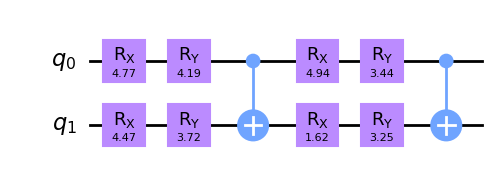

In [2]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = [4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712,
                   3.44120060, 3.24526326, 0.91836107, 1.32971456, 4.80863498, 0.54593609]

size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

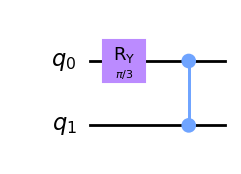

In [20]:
state = QuantumCircuit(2)
state.ry(np.pi/3, 0)
state.cz(0, 1)
state.draw('mpl')

In [21]:
'''
Extract the matrix representation of the state \rho_S
'''
psi = np.array(DensityMatrix.from_instruction(state.reverse_bits()))
rho = pt(psi, [2], [2, 2])
print(rho)

[[0.75     +0.j 0.4330127+0.j]
 [0.4330127+0.j 0.25     +0.j]]


In [22]:
'''
Define matrix representations of required gates.
'''
I = np.array([[1, 0], [0, 1]], dtype=complex)
U0_1qubit = np.array([[np.exp(1j*np.pi/3), 0], [0, np.exp(-1j*np.pi/3)]], dtype=complex)
U0 = np.kron(U0_1qubit, U0_1qubit)
U2 = np.matmul(U0, U0)

In [23]:
'''
Create list of group elements.
'''
lis = []
lis.append(np.kron(I, I))
lis.append(U0)
lis.append(U2)

In [24]:
'''
SDP to calculate the Fidelity. Refer to Section 5.
'''
shape = rho.shape

X = cp.Variable(shape, complex=True)
omega = cp.Variable(U0.shape, complex=True)
G = cp.bmat([[rho, X.H],[X, pt(omega, [2], [2, 2])]])

c = [omega>>0, G>>0, cp.real(cp.trace(omega))==1]

'''
Add the constraint to ensure that sig is G-Symmetric extendible
'''
for item in lis:
    c.append(omega@item == item@omega)

obj = cp.Maximize(cp.real(cp.trace(X)))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

WARN: A->p (column pointers) not strictly increasing, column 20 empty
WARN: A->p (column pointers) not strictly increasing, column 25 empty
WARN: A->p (column pointers) not strictly increasing, column 30 empty
WARN: A->p (column pointers) not strictly increasing, column 35 empty
Root Fidelity is : 0.866027336289654


In [25]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 0.7500033472009535
